## CommitPackFt dataset exploration

Let's do some data exploration of [CommitPackFt](https://huggingface.co/datasets/bigcode/commitpackft) dataset!

We will look at 6 popular programming languages: `Python`, `JavaScript`, `Java`, `Go`, `C++` and `Rust`. The same set of languages is used for [HumanEvalPack](https://huggingface.co/datasets/bigcode/humanevalpack) benchmark introduced in [this](https://arxiv.org/pdf/2308.07124.pdf) paper.

In [1]:
# some imports

import datasets
import json
import numpy as np
from matplotlib import pyplot as plt
from utils import calculate_from_datasets, get_changes_count
from constants import COMMIT_PACK_FT_DATASET, COMMIT_PACK_FT_LANG, PYTHON, JAVASCRIPT, JAVA, GO, CPP, RUST

Defining some constants that we will use:

In [2]:
# fetching the dataset parts corresponding to the chosen 6 programming languages

cp_dataset = [datasets.load_dataset(COMMIT_PACK_FT_DATASET, lang)['train'] for lang in COMMIT_PACK_FT_LANG]
print(cp_dataset[PYTHON])

Dataset({
    features: ['commit', 'old_file', 'new_file', 'old_contents', 'new_contents', 'subject', 'message', 'lang', 'license', 'repos'],
    num_rows: 56025
})


### Take a look at a sample
Let's take a look at a sample from the python subset!

In [4]:
# a sample from the python subset

sample = cp_dataset[PYTHON][5]
print(json.dumps(sample, indent=2))

{
  "commit": "f183b471bf92c03bb5353b02009e3287ffe06ae7",
  "old_file": "txircd/modules/umode_i.py",
  "new_file": "txircd/modules/umode_i.py",
  "old_contents": "from txircd.modbase import Mode\n\nclass InvisibleMode(Mode):\n\tdef namesListEntry(self, recipient, channel, user, representation):\n\t\tif channel not in recipient.channels and \"i\" in user.mode:\n\t\t\treturn \"\"\n\t\treturn representation\n\nclass Spawner(object):\n\tdef __init__(self, ircd):\n\t\tself.ircd = ircd\n\t\n\tdef spawn(self):\n\t\treturn {\n\t\t\t\"modes\": {\n\t\t\t\t\"uni\": InvisibleMode()\n\t\t\t}\n\t\t}\n\t\n\tdef cleanup(self):\n\t\tself.ircd.removeMode(\"uni\")",
  "new_contents": "from txircd.modbase import Mode\n\nclass InvisibleMode(Mode):\n\tdef namesListEntry(self, recipient, channel, user, representation):\n\t\tif channel.name not in recipient.channels and \"i\" in user.mode:\n\t\t\treturn \"\"\n\t\treturn representation\n\nclass Spawner(object):\n\tdef __init__(self, ircd):\n\t\tself.ircd = irc

### What is interesting?

> What parameters are interesting to look at and, at the same time, could be calculated numerically?
> 
> We could look at the message lengths distributions and the distributions of number of changes introduced by a commit.
> It's also interesting to look, weather these two values have a linear correlation or not. (Maybe the more changes are introduced, the longer will be the explanations?)

We have features of a single item outlined above. The most interesting ones are:
* `old_contents` and `new_contents`: from them we will be able to derive, for example, the number of changes introduced by a commit.
* `message` and `subject`: from them we will be able to derive another interesting value: the lengths of a message.

### Message lengths

Let's calculate the message lengths for each language. We will calculate the length in words (words being character sequences separated with whitespace characters).

In [5]:
def get_message_lengths(dataset: datasets.Dataset):
    return [len(item['message'].split()) for item in dataset]

In [6]:
message_lengths = calculate_from_datasets(cp_dataset, get_message_lengths) # a list of lengths of items for each language

100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


In [7]:
message_length_means = [np.mean(message_lengths[lang]) for lang in range(len(cp_dataset))] # a list of mean lengths for each language

message_length_uniques, message_length_counts = zip(*[np.unique(lengths, return_counts=True) for lengths in message_lengths])

message_length_distributions = [np.zeros(np.max(lengths) + 1) for lengths in message_lengths] # a distribution of lengths for each language
for lang in range(len(cp_dataset)):
    message_length_distributions[lang][message_length_uniques[lang]] = message_length_counts[lang]

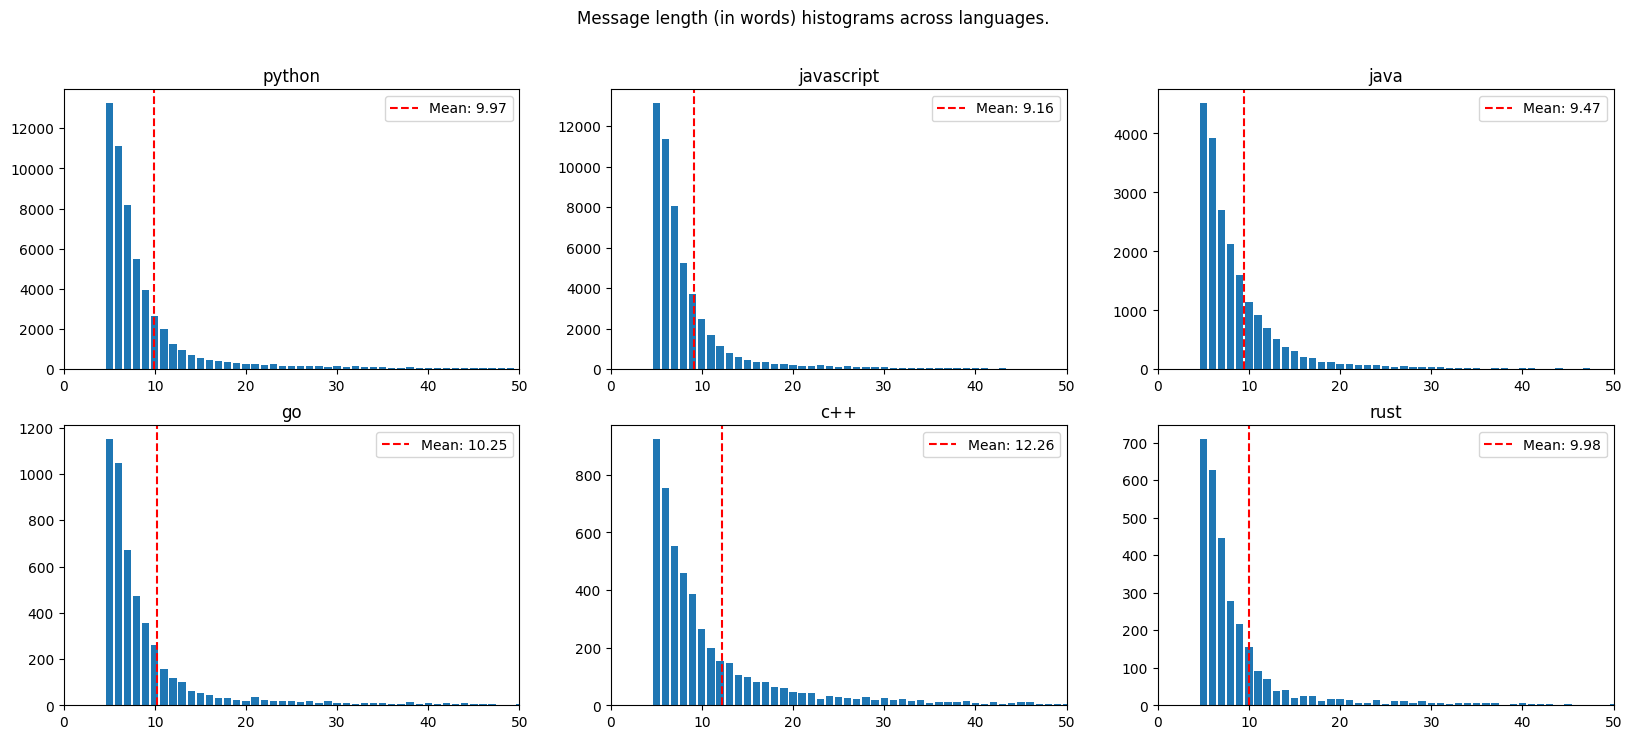

In [8]:
MAX_LENGTH_SLICE = 50 # you can change it if you want to see a full picture
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

for lang in range(len(cp_dataset)):
    x = lang // 3
    y = lang % 3
    
    # plot the distribution of a language lang
    ax[x, y].bar(range(len(message_length_distributions[lang])), message_length_distributions[lang])
    
    # plot length mean
    ax[x, y].axvline(x=message_length_means[lang], color='red', linestyle='--', label=f'Mean: {message_length_means[lang]:.2f}')
    
    ax[x, y].set_xlim(0, min(np.max(message_length_uniques[lang]), MAX_LENGTH_SLICE))
    
    ax[x, y].set_title(COMMIT_PACK_FT_LANG[lang])
    ax[x, y].legend()

plt.suptitle("Message length (in words) histograms across languages.")
plt.show()

I truncated the plots on lengths $50$ so that they are easy to look at. The tails of the distributions are long. For example, for python the lengths reach around $500$ words. You can look at the full picture by setting `MAX_LENGTHS_SLICE` to $1000$.

I also outlined in the plots the mean values of the lengths by a red line and a value in the legend.

We can see that:
* The lengths is at least 5, which is ensured by one of the filters ("Words" filter) that the authors used to clean an original dataset. All filters can be found in Appendix D of the [paper](https://arxiv.org/pdf/2308.07124.pdf).
* The height of lengths histogram is decreasing rapidly with the lengths growing. It follows the expectations: people usually write smaller messages.
* Some languages may have higher mean values that the other. For example, C++ messages, on average, are 2 words longer that the messages from other popular languages. Either C++ requires longer explanations or this scientifically proves that C++ users are "душнилы"(I haven't found an English equivalent for the word).

### Samples of different lengths

Let's just look at some shortest/longest/average samples. 

The shortest and longest ones are for python. And the average ones are printed one per language.

In [9]:
python_order = np.argsort(message_lengths[PYTHON])

In [10]:
print("Some examples of short messages:")
for i in range(20):
    print(f"==============================================\n"
          f"{cp_dataset[PYTHON][int(python_order[i])]['message']}")

Some examples of short messages:
Implement fetching all monitored data

Disable message signing for now

Add CCS811 to device factory

Add logging to script test

Test WSGI start_response is called

Rename the only context processor.

Update default smart contract addresses

Add RefusePickup class (for parsing)

Update Django requirements for 1.8

Use 2to3 for Python 3

Drop support for Python 2.6

Add integrator property for Operations

Add basic tests for configuration

Add validation to example script.

Add checking empty product code

Remove special case from StringIO.

Add Mike as a contributor.

Fix sorting of the imports.

Fix warnings under Python 3

Add fragment_keys method to PageQuerySet


Seem to be regular commit messages...

In [11]:
print("Some examples of long messages:")
for i in range(1, 3):
    print(f"============================================================================================\n"
          f"{cp_dataset[PYTHON][int(python_order[-i])]['message']}")

Some examples of long messages:
Add script to bring up bluetooth network

<rant>
I haven't managed to find any good documentation on this (or pretty much
anything bluez 4.x related) at all (the blueman source implements this,
but it's not the easiest source in the world to follow) - this was
created after a lot of trial and error staring at the bluez dbus
interface in d-feet until I saw the bnep0 interface appear! Only for it
to disappear a moment later :(

Unfortunately, it turns out that using dbus-send is not an option
because bluez removes the bnep0 interface the moment the dbus client
goes away (WHY???). I'm beginning to think that the bluez 4.x developers
are purposefully trying to make the console experience as unusable as
possible... For the love of god would someone please implement a curses
version of blueman... Please?
</rant>

So... Here's the python version that keeps the dbus connection open
until enter is pressed so that the bnep0 interface doesn't suddenly go
away.

Thi

Long messages contain some long explanations/instructions. Including them in the instruction description may increase the quality (compared to including only subjects) of synthesising and fixing, but I doubt that the performance increase would be significant as there aren't many long messages. 

"Average-sized" messages in terms of length for every language:

In [12]:
for lang in range(len(cp_dataset)):
    mean_length = np.round(message_length_means[lang]).astype(np.int32)
    average_message_index = np.where(message_lengths[lang] == mean_length)[0][0]
    print(f"======================== {COMMIT_PACK_FT_LANG[lang]} [len={mean_length}] ========================\n{cp_dataset[lang][int(average_message_index)]['message']}")

======================== python [len=10] ========================
Fix implied_group, it still refers to the old module name

======================== javascript [len=9] ========================
Add some fugly javascript to pre-fill parent wiki page.

======================== java [len=9] ========================
Enable service compositions command to instantiate the linked ontology
======================== go [len=10] ========================
Add runc to usable executor options!

Signed-off-by: Eric Myhre <2346ad27d7568ba9896f1b7da6b5991251debdf2@exultant.us>

======================== c++ [len=12] ========================
Test was restored, interval [<v>-1,<v>+1] was set for hue, saturation and value.

======================== rust [len=10] ========================
Fix hostname, some IRC servers doesn't accept @ in hostnames


### Number of changes

Now let's take a look at the number of changes introduced by commits.

First, a sample. We consider changes as additions and deletions only. So a change of a line would count as two changes: one addition and one deletion.

In [13]:
old_text = cp_dataset[PYTHON][1]['old_contents']
new_text = cp_dataset[PYTHON][1]['new_contents']

changes_count, diff = get_changes_count(old_text, new_text, return_diff=True)

print(f"Diff:\n{diff}\nNumber of changes: {changes_count}")


Diff:
@@ -13,5 +13,5 @@ 
 
 def test_forecast():
-    regex = u'Lappeenranta, Finland: tomorrow: \d+.\d-\d+.\d \xb0C \(.*?\), in 2 days: \d+.\d-\d+.\d \xb0C \(.*?\), in 3 days: \d+.\d-\d+.\d \xb0C \(.*?\)'
+    regex = u'Lappeenranta, FI: tomorrow: \d+.\d-\d+.\d \xb0C \(.*?\), in 2 days: \d+.\d-\d+.\d \xb0C \(.*?\), in 3 days: \d+.\d-\d+.\d \xb0C \(.*?\)'
     check_re(regex, module_openweather.command_forecast(bot, None, "#channel", 'lappeenranta')[1])

Number of changes: 2


In [14]:
def get_changes(dataset: datasets.Dataset):
    return [get_changes_count(item['old_contents'], item['new_contents']) for item in dataset]

In [15]:
changes = calculate_from_datasets(cp_dataset, get_changes) # a list of change counts of items for each language 

100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


In [16]:
change_means = [np.mean(lang_changes) for lang_changes in changes] # a list of mean change counts for each language

change_uniques, change_counts = zip(*[np.unique(lang_changes, return_counts=True) for lang_changes in changes])

change_distributions = [np.zeros(np.max(lang_changes) + 1) for lang_changes in changes] # a distribution of change counts for each language
for lang in range(len(cp_dataset)):
    change_distributions[lang][change_uniques[lang]] = change_counts[lang]

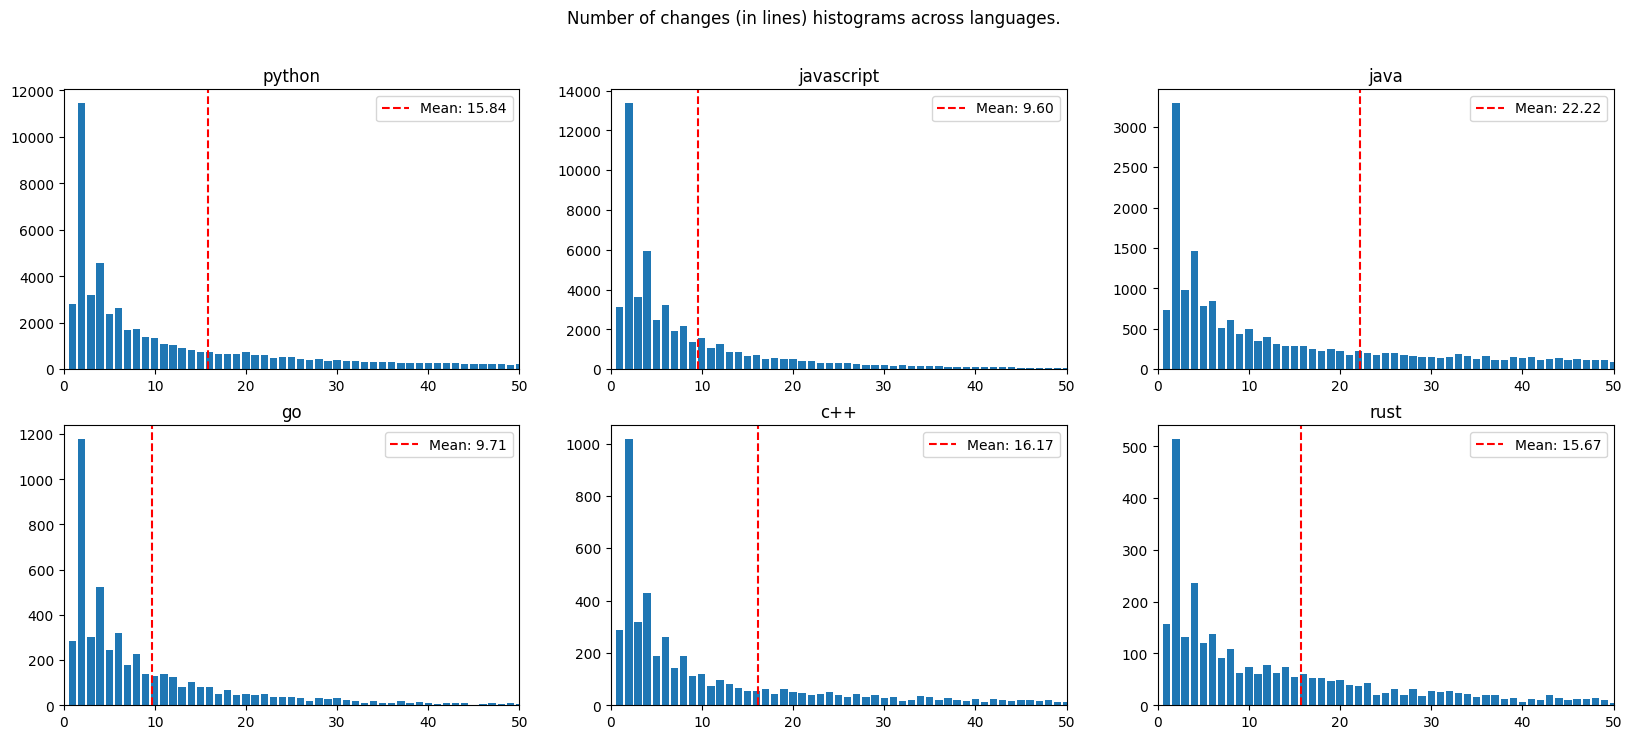

In [17]:
MAX_CHANGE_COUNT_SLICE = 50
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

for lang in range(len(cp_dataset)):
    x = lang // 3
    y = lang % 3
    
    # plot the distribution of a language lang
    ax[x, y].bar(range(len(change_distributions[lang])), change_distributions[lang])
    
    # plot length mean
    ax[x, y].axvline(x=change_means[lang], color='red', linestyle='--', label=f'Mean: {change_means[lang]:.2f}')
    
    ax[x, y].set_xlim(0, min(np.max(changes[lang]), MAX_CHANGE_COUNT_SLICE))
    
    ax[x, y].set_title(COMMIT_PACK_FT_LANG[lang])
    ax[x, y].legend()

plt.suptitle("Number of changes (in lines) histograms across languages.")
plt.show()

I, once again truncated the length of the plots, you can change the `MAX_CHANGE_COUNT_SLICE` to see a full picture.

The mean values are outline in the same way as well.

We can see that:
* The height of the histogram tends to decrease with the number of changes growing. It's natural: the commits are usually small.
* There are spikes of even changes (2, 4, 6, 8) on some graphs. I believe, these commits should mostly be respective (1, 2, 3, 4)-line changes. The mode change number is two, which corresponds to the one-line change.
* The mean value differs across languages once again. Java has the longest tail and the highest mean number of changes. Not sure why, my hypothesis is that in Java there is much more "boilerplate" code than in other languages.

### Do they depend on each other?

So the question we asked in the beginning: does the number of changes and the lengths of a messages depend on each other?

Let's look at the plots!

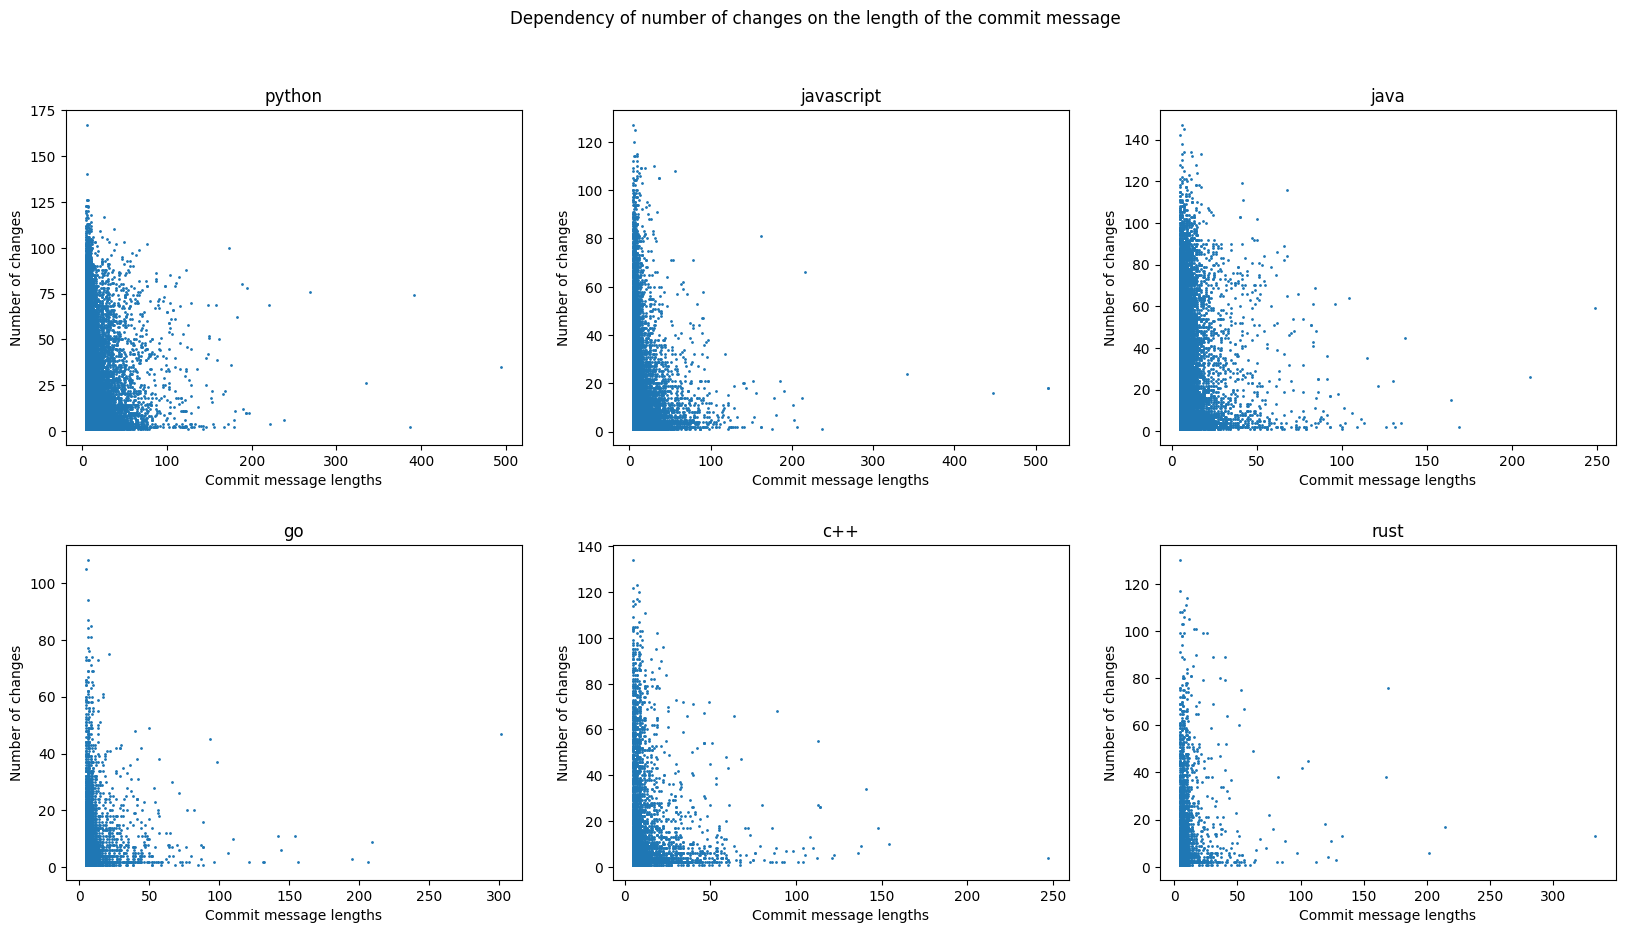

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for lang in range(len(cp_dataset)):
    x = lang // 3
    y = lang % 3
    
    ax[x, y].scatter(message_lengths[lang], changes[lang], s=1)
    
    ax[x, y].set_title(COMMIT_PACK_FT_LANG[lang])
    
    ax[x, y].set_xlabel("Commit message lengths")
    ax[x, y].set_ylabel("Number of changes")

plt.subplots_adjust(hspace=0.3)
plt.suptitle("Dependency of number of changes on the length of the commit message")
plt.show()

Doesn't look like that :(

I calculated also Pearson coefficients just in case there is any linear relation that I don't see, but didn't include it here. The coefficients were all near 0 with p-values near 0. So at least there's no linear relation.

From the plots, it looks like they might relate inversely, but it's misleading, because with higher commit message lengths the number of commits becomes small (meaning we don't have enough samples). And because of it such plots make sense.

Worth noting, that there are many more languages in CommitPackFt dataset. You can look at them just by modifying the variable that stores the languages.

## Commits as a source for instructions: pros and cons

### Alternatives
Pros and cons exist only in comparison. So what are the alternatives for the source of instructions for code editing?

The ones I came up with are:
* Generation of a natural language explanation using LLMs given two versions of the same file: the pitfalls of this approach are described in the paper (reliance on a stronger model, legal issues, etc.). So we won't compare to it.
* Buying developers that would create instructions for the changes: unreasonably expensive, even more expensive than coffee! (probably)
* Using forums like StackOverflow to scrape code, problems with it and explanations of solutions: seems like a relatively valid source.
* Getting instructions from code review comments: seems like a good source as well.
* Getting instructions from commit messages: as described in a paper...

Scraping forums and getting instruction from code reviews seem to be valid alternatives to commit instructions. So let's compare to them.

### Forums like StackOverflow

* It's definitely easier to collect information from commit messages than to scrape it from forums. Seems like for each forum we would need a different approach.
* It also seems like in the end the data from forums would be of a way worse quality, because there is no enforced structure for forum messages.
* It may be unclear, how to create instructions from the forum questions. They, once again, have no structure. For commit messages, on the other hand, most people try to follow some guidelines like [this](https://gist.github.com/robertpainsi/b632364184e70900af4ab688decf6f53) one.
* Forums have linked discussions, from which we could derive iterative refinement of the solution. Commits provide it as well to a certain extent, but it's harder to extract it from commits. Linked discussions may help by providing negative examples of changes.
* Commit messages, as we saw, are mostly short and may lack explanation. Whereas in the forums people usually explain well, how to fix a problem.
* Because of a genre of forums, where people ask questions, the class of "how to fix" questions would be predominant. On the other hand, for example, 25% of commits are about new feature implementation (see Figure 2 in the [paper](https://arxiv.org/pdf/2308.07124.pdf)).

### Code review comments

* The main difference between commit messages in code review comments is in the author of a natural language comment/message:
    * In case of commit messages the author is the author of the code 
    * In case of code reviews the author sees the code for the first time
* Because of this, some differences appear:
    * The commit messages are way less explanatory: the author of the code had already though everything through about the changes. They just create a short message like "Fix \<short name of a bug\>". Whereas for code reviews, the reviewer is forced to explain, for example, why the code is a bug.
    * The code reviewer may just ask questions or misunderstand the changes. We would have to sort it out. It's not clear how (just keeping comments without answers doesn't help, because colleagues may have talked about it in person).
* As with forums, the predominant class for code reviews would be comments about editing, not creation.
* As with forums, code reviews may have several iterations of refinement.

### Summary
In general, the main drawbacks of using commit messages are:
* The lack of explanation
* Only one perspective (the author of the code and the author of the messages is the same)

Therefore, it could be useful to combine several sources of instruction information. 
This way we will mend most of the problems with every single source: 
* The "fix \<something\>" class wouldn't be as predominant as in not commit sources.
* We will get more examples with better explanations on what, for instance, a bug is about
* And we will gain comments with different perspectives on code

P.S. These are just my thoughts. There should probably be papers that examine different approaches.